## **Deep Learning Made Easy**

----

Author:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>.

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

This is a notebook to demonstrate how easy is to create "new" deep neural networks (DNNs) by changing a few lines of code of previously proposed models and, hence, create new architectures. <a href="https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py">VGG</a> and <a href="https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py">ResNet</a> deep convolutional neural networks (CNNs) by the PyTorch Team are modified to create two new architectures: VGG12BN and ResNet-14.  

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to "root" directory
%cd /content/drive/My Drive/Colab Notebooks/pyTorch/dlme
%ls

/content/drive/My Drive/Colab Notebooks/pyTorch/dlme
imagenettetvt320/     __pycache__/                         vggmodified.py
imagenettetvt320.zip  PyTorch_VGG_ResNet_ResNetonly.ipynb
out/                  resnetmodified.py


## **Create directories and unzip the datasets**
----

Create the following directories under the "root" directory:



1.   ```imagenettetvt320```. It will contain the <a href="https://github.com/fastai/imagenette">imagenette320 px</a> datasets. However, we split the original validation dataset into two: validation with 1/3 of the images of the original validation set, and 2/3 of the images compose the test dataset; 
2.   ```out```. It is to store the best model during training and other relevant outputs.

<br>

After that, run the command below only once to unzip all datasets (training, validation, test). It is assumed that the .zip file (imagenettetvt320.zip) has already been uploaded to the "root" Google Drive's directory.



In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320.zip" -d "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320"


A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/n03417042_19047.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/ILSVRC2012_val_00037947.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/n03417042_10289.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/ILSVRC2012_val_00031313.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/n03417042_9698.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/n03417042_553.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320/train/garbageTruck/n03417042_3104.JPEG  
  inflating: /content/drive/My Drive/Colab Notebooks/p

## **Modified models**
----

Below, ```vggmodified``` and ```resnetmodified``` are the files with the modifications accomplished to created the two new models. Take a look at them to precisely see the very few modifications which have been made. 

In [ ]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os
import time
import torchvision
from torchvision import datasets, transforms # models: out
from vggmodified import * # VGG modified
from resnetmodified import * # ResNet modified
from prettytable import PrettyTable
from torch.autograd import Variable
plt.ion()   # Interactive mode

In [ ]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

In [ ]:
# Custom dataset that includes image file paths. Extends 
# torchvision.datasets.ImageFolder
class FileNames(datasets.ImageFolder):
    
    # Override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # This is what ImageFolder normally returns 
        original_tuple = super(FileNames, self).__getitem__(index)
        # The image file path
        path = self.imgs[index][0]
        # Make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

## **Define important variables**
----

Here, we define the classes and also some hyper-parameters.

In [ ]:
# The directory of the datasets
data_dir = 'imagenettetvt320'

# All relevant outputs are here
output_dir = '/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/out' 

# The number of classes
num_classes = 10

# Variables related to the selected CNN
indic = '' # Indicator of the selected CNN
hei_wid = 224 # Images will be cropped to 224 x 224

# Hyper-parameters
num_epochs = 10 # Number of epochs
batch_size = 4 # The size of input data took for one iteration
learning_rate = 0.001 # Learning rate
moment = 0.9 # Momentum

## **Select the CNN and load data**
----

Select the CNN and load data. All images are cropped below to 224 x 224 (variable ```hei_wid```). Moreover, note that dynamic data augmentation and 
normalisation are used for the training dataset only. For the validation and test datasets, only normalisation.







In [ ]:
print("Select the CNN: ")
print("Press '1' for VGG16BN.")
print("Press '2' for VGG19BN.")
print("Press '3' for VGG12BN (new).")
print("Press '4' for ResNet-18.")
print("Press '5' for ResNet-34.")
print("Press '6' for ResNet-14 (new).")
opt = input("Enter your choice:")
if opt =='1':
	indic = 'VGG16BN'
	print("You selected VGG16BN!")
elif opt =='2':
	indic = 'VGG19BN'
	print("You selected VGG19BN!")
elif opt =='3':
	indic = 'VGG12BN'
	print("You selected VGG12BN (new)!") 
elif opt =='4':
	indic = 'ResNet-18'
	print("You selected ResNet-18!")
elif opt =='5':
	indic = 'ResNet-34'
	print("You selected ResNet-34!") 
elif opt =='6':
  indic = 'ResNet-14'
  print("You selected ResNet-14 (new)!")
else:
  print("Invalid Option!") 

# File that contains the best model obtained during the training phase
best_model_full = output_dir+'/best_model_'+indic+'.pt' 

# Tranformations for each dataset. Note that dynamic data augmentation and
# normalisation are used for the training dataset only. For the validation
# and test datasets, only normalisation.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(hei_wid),
        transforms.RandomHorizontalFlip(),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
        
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(hei_wid),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),                        
        transforms.CenterCrop(hei_wid), 
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

image_datasets = {x: FileNames(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Just checking the sizes
print('\nDataset sizes: ', dataset_sizes)
print('Dataloaders sizes: ', len(dataloaders))
class_names = image_datasets['train'].classes
class_namesv = image_datasets['val'].classes
class_namest = image_datasets['test'].classes
print('Training classes: ', class_names)
print('Training lengths: ', len(class_names))
print('Validation classes: ', class_namesv)
print('Validation lengths: ', len(class_namesv))
print('Test classes: ', class_namest)
print('Test lengths: ', len(class_namest))
print('Height x Width: {} x {}'.format(hei_wid,hei_wid))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Select the CNN: 
Press '1' for VGG16BN.
Press '2' for VGG19BN.
Press '3' for VGG12BN (new).
Press '4' for ResNet-18.
Press '5' for ResNet-34.
Press '6' for ResNet-14 (new).
Enter your choice:6
You selected ResNet-14 (new)!

Dataset sizes:  {'train': 9469, 'val': 1309, 'test': 2616}
Dataloaders sizes:  3
Training classes:  ['cassetePlayer', 'chainShaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Training lengths:  10
Validation classes:  ['cassetePlayer', 'chainSaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Validation lengths:  10
Test classes:  ['cassetePlayer', 'chainShaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Test lengths:  10
Height x Width: 224 x 224


One batch - training dataset: torch.Size([4, 3, 224, 224])

Each image of the batch:
Image: 0 - Input shape: torch.Size([3, 224, 224]) - Class: chainShaw
Image: 1 - Input shape: torch.Size([3, 224, 224]) - Class: garbageTruck
Image: 2 - Input shape: torch.Size([3, 224, 224]) - Class: gasPump
Image: 3 - Input shape: torch.Size([3, 224, 224]) - Class: golfBall
The "image" itself:  tensor([[[-0.8353, -0.8275, -0.8196,  ..., -0.5451, -0.5059, -0.4902],
         [-0.8275, -0.8196, -0.8039,  ..., -0.5686, -0.5216, -0.5059],
         [-0.8196, -0.8039, -0.7804,  ..., -0.6078, -0.5529, -0.5216],
         ...,
         [ 0.7882,  0.7882,  0.7961,  ..., -0.7098, -0.6471, -0.6078],
         [ 0.7882,  0.7882,  0.7882,  ..., -0.7020, -0.6392, -0.6000],
         [ 0.7882,  0.7882,  0.7882,  ..., -0.6941, -0.6314, -0.5922]],

        [[-0.7176, -0.7176, -0.7255,  ..., -0.4667, -0.4667, -0.4667],
         [-0.7098, -0.7020, -0.7020,  ..., -0.4902, -0.4824, -0.4824],
         [-0.6941, -0.6863, -0.670

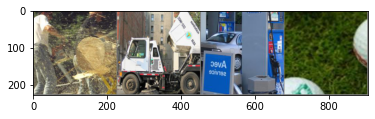

chainShaw - garbageTruck - gasPump - golfBall


In [ ]:
# Just visualising some images
def visualise_images(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch: training dataset
dataiter = iter(dataloaders['train'])
images, labels, paths = dataiter.next()
print('One batch - training dataset:', images.shape)

print('\nEach image of the batch:')
for i in range(labels.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, images[i].shape, image_datasets['train'].classes[labels[i]]))
  if i == (labels.shape[0]-1):
    print('The "image" itself: ', images[i])

# Show images
visualise_images(torchvision.utils.make_grid(images))
# Print labels
print(' - '.join('%5s' % image_datasets['train'].classes[labels[j]] for j in range(batch_size)))

## **Instantiate the selected CNN**
----

Now, we instantiate the previous selected CNN.


In [ ]:
# ResNet: Number of input features for the last layer (fully-connected)
num_ftrs = -1 
if opt =='1':
  net = vgg16_bn()
elif opt =='2':
  net = vgg19_bn()
elif opt =='3':
  net = vgg12_bn()
elif opt =='4':
  net = resnet18()
  num_ftrs = net.fc.in_features
  print('Input features - ResNet-18:', num_ftrs) 
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='5':
  net = resnet34()
  num_ftrs = net.fc.in_features
  print('Input features - ResNet-34:', num_ftrs)
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='6':
  net = resnet14()
  num_ftrs = net.fc.in_features
  print('Input features - ResNet-14:', num_ftrs)
  net.fc = nn.Linear(num_ftrs, num_classes)  
else:
  print("Invalid Option!")
     
net = net.to(device)

Input features - ResNet-14: 512


## **Define loss function and optimiser**

----

The <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. Optimiser is SGD, the learning rate and momentum have already been defined.

In [ ]:
# Cross-entropy Loss
loss_function = nn.CrossEntropyLoss()

# All parameters are being optimised
optimiser = optim.SGD(net.parameters(), lr=learning_rate, momentum=moment)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

## **Run the Training Phase**
----

Now, we can run the training phase. 



In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []
best_loss_validation = sys.float_info.max
best_epoch = sys.float_info.max
train_time_init = time.time()
#### Main training loop: Begin
for epoch in range(num_epochs):
  #### Each epoch has a training and validation phase: Begin
  for phase in ['train', 'val']:
    if phase == 'train':
      net.train() # Set model to training mode
    else:
      net.eval()  # Set model to evaluate mode
   
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data: Begin
    for images, labels, paths in dataloaders[phase]: 
      images = Variable(images).to(device) # Send to GPU
      labels = Variable(labels).to(device) # Send to GPU
    
      optimiser.zero_grad()
      with torch.set_grad_enabled(phase == 'train'):
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)
        
        # Backward + optimise only if in training phase. 
        if phase == 'train':
          loss.backward()
          optimiser.step()
    
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
    # Iterate over data: End

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase] 
    print('Phase: {}, Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(
                 phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
    
    if phase == 'train': # Training
      train_losses.append(epoch_loss)
      train_acc.append(epoch_acc) 
    else: # Validation
      val_losses.append(epoch_loss)
      val_acc.append(epoch_acc) 
      if (epoch_loss < best_loss_validation):
        best_loss_validation = epoch_loss
        best_epoch = epoch + 1
        if os.path.exists(best_model_full):
          os.remove(best_model_full)
          print('####### Validation loss: previous best model removed!!!!')
        else:
          print("####### Validation loss: there is no saved model yet!!!!")
        torch.save(net.state_dict(), best_model_full)
        print('####### Validation loss: new best model saved in Epoch: {} !!!!'.format(str(epoch + 1)))
  #### Each epoch has a training and validation phase: End
#### Main training loop: End
train_time_end = time.time() - train_time_init

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Phase: train, Epoch 1/10, Loss: 2.0019, Accuracy: 0.2983
Phase: val, Epoch 1/10, Loss: 2.5338, Accuracy: 0.3850
####### Validation loss: there is no saved model yet!!!!
####### Validation loss: new best model saved in Epoch: 1 !!!!
Phase: train, Epoch 2/10, Loss: 1.6872, Accuracy: 0.4298
Phase: val, Epoch 2/10, Loss: 1.8219, Accuracy: 0.4905
####### Validation loss: previous best model removed!!!!
####### Validation loss: new best model saved in Epoch: 2 !!!!
Phase: train, Epoch 3/10, Loss: 1.5345, Accuracy: 0.4834
Phase: val, Epoch 3/10, Loss: 1.4777, Accuracy: 0.5913
####### Validation loss: previous best model removed!!!!
####### Validation loss: new best model saved in Epoch: 3 !!!!
Phase: train, Epoch 4/10, Loss: 1.4130, Accuracy: 0.5422
Phase: val, Epoch 4/10, Loss: 1.2346, Accuracy: 0.6104
####### Validation loss: previous best model removed!!!!
####### Validation loss: new best model saved in Epoch: 4 !!!!
Phase: train, Epoch 5/10, Loss: 1.3363, Accuracy: 0.5652
Phase: val, Epo

## **Training phase: results**
----

Just showing the loss and accuracy during the training phase: training and validation datasets.

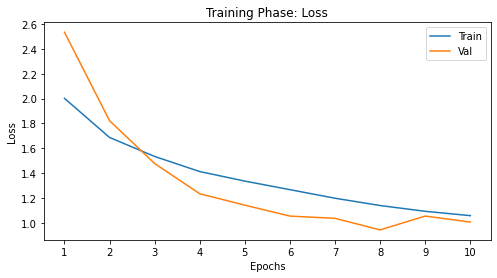

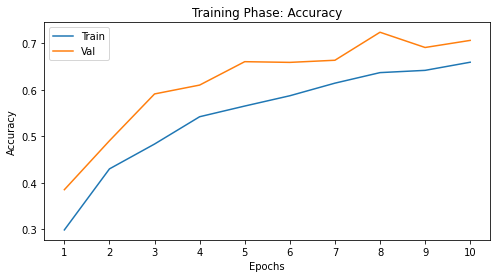

In [ ]:
x = range(1,len(train_losses)+1)

plt.figure(figsize=(8,4))
plt.title("Training Phase: Loss")
plt.plot(x,train_losses,label="Train")
plt.plot(x,val_losses,label="Val")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{output_dir}/training_loss_"+indic+".png")
plt.show()

plt.figure(figsize=(8,4))
plt.title("Training Phase: Accuracy")
plt.plot(x,train_acc,label="Train")
plt.plot(x,val_acc,label="Val")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{output_dir}/training_acc_"+indic+".png")
plt.show()

## **Load the model**
----

You can load your best model to use in the inference phase. 

In [ ]:
if opt =='1':
  net = vgg16_bn()
elif opt =='2':
  net = vgg19_bn()
elif opt =='3':
  net = vgg12_bn()
elif opt =='4':
  net = resnet18()
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='5':
  net = resnet34()
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='6':
  net = resnet14()
  net.fc = nn.Linear(num_ftrs, num_classes)
else:
  print("Invalid Option!")
     
net = net.to(device)
net.load_state_dict(torch.load(best_model_full))
print("Best {} model loaded!".format(indic))

Best ResNet-14 model loaded!


## **Inference phase**

----

In the inference phase, we measure the performance of our model based on the test dataset. 


In [ ]:
am_training = net.training
print('Am I training? ', am_training)
net.eval()
am_training = net.training
print('Am I training? ', am_training)
inference_loss = 0.0
inference_corrects = 0
phase = 'test'

infer_time_init = time.time()
with torch.no_grad():
  # Iterate over data: Begin
  for images, labels, paths in dataloaders[phase]: 
      images = Variable(images).to(device) # Send to GPU
      labels = Variable(labels).to(device) # Send to GPU

      outputs_infer = net(images)
      _, preds_infer = torch.max(outputs_infer,1)
      loss_infer = loss_function(outputs_infer, labels)

      inference_loss += loss_infer.item() * images.size(0)
      inference_corrects += torch.sum(preds_infer == labels.data)
  # Iterate over data: End

final_inference_loss = inference_loss / dataset_sizes[phase]
final_inference_acc = inference_corrects.double() / dataset_sizes[phase]

infer_time_end = time.time() - infer_time_init
print('\nTraining and inference in {:.0f}m {:.0f}s  OR  {:.0f}s'.format(
        (train_time_end + infer_time_end) // 60, 
        (train_time_end + infer_time_end) % 60,
         train_time_end + infer_time_end))

print('\nLoss of {}: {:.4f}'.format(indic, final_inference_loss))
print()
print('Accuracy of {}: {:.4f}'.format(indic, final_inference_acc))

Am I training?  True
Am I training?  False

Training and inference in 21m 13s  OR  1273s

Loss of ResNet-14: 0.9094

Accuracy of ResNet-14: 0.7209


In [ ]:
plt.ioff()